# Multiway MGC K-sample test

We run a 2-way MGC k-sample test to determine independence between groups.

In [24]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
#from hyppo.independence import MGC
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap

import sys; sys.path.append('../')
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [14]:
## Define paths
#base_dir = Path('/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/')
base_dir = Path('/mnt/ssd3/ronan/data/gcca_old_min_rank-ZG3/')

In [15]:
groups, labels = get_latents(base_dir, flag='_gcca-zg')

In [5]:
ways = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
X,Y = k_sample_transform(groups, ways=ways)

In [10]:
X = X[:,:,:3].reshape(X.shape[0],-1)

In [8]:
stat, pvalue, mgc_dict = multiscale_graphcorr(X, Y, workers=-1, reps=1000)

In [9]:
pvalue

0.019

Optimal Scale: [228, 3]


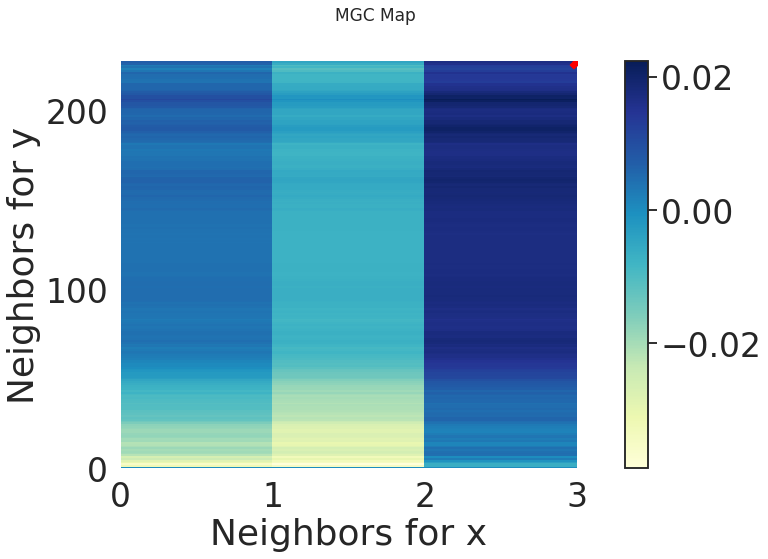

In [12]:
# store mgc outputs as variables
opt_scale = mgc_dict["opt_scale"]
mgc_map = mgc_dict["mgc_map"]

print("Optimal Scale:", opt_scale)
fig, (ax, cax) = plt.subplots(ncols=2, figsize=(9.45, 7.5),  gridspec_kw={"width_ratios":[1, 0.05]})

# draw heatmap and colorbar
ax = sns.heatmap(mgc_map, cmap="YlGnBu", ax=ax, cbar=False)
fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
ax.invert_yaxis()

# optimal scale
ax.scatter(opt_scale[1], opt_scale[0], marker='X', s=200, color='red')

# make plots look nice
fig.suptitle("MGC Map", fontsize=17)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Neighbors for x')
ax.set_ylabel('Neighbors for y')
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 100, 200])
ax.xaxis.set_tick_params()
ax.yaxis.set_tick_params()
cax.xaxis.set_tick_params()
cax.yaxis.set_tick_params()
plt.show()

## Old method

In [6]:
X,Y = k_sample_transform(groups)

In [7]:
X = X[:,:,:3].reshape(X.shape[0],-1)

In [8]:
stat, pvalue, mgc_dict = MGC().test(X, Y, workers=-1)

In [9]:
pvalue

0.491

The k-sample transform generates Y labels uses the euclidean distance. Let there be $K$ ways and two sets of sample labels $x,y \in Y$ that agree on $h \leq K$ of the ways. Then taking the euclidean distance we achieve
$$||x-y||_2 = \sqrt{2(K-h)}.$$
What we want, however, is simply $||x-y|| = K-h$. Whether this monotonic transformation has an effect, unknown. So, we manually construct the desired distances from the euclidean distances.

In [9]:
from sklearn.metrics.pairwise import euclidean_distances

In [97]:
X_dist = euclidean_distances(X,X)
Y_dist = (euclidean_distances(Y,Y)**2)/2

In [98]:
stat, pvalue, mgc_dict = MGC(compute_distance=None).test(X_dist, Y_dist,workers=-1)

In [99]:
pvalue

0.558

## Doubly Centered

In [10]:
Dx = X[:,:,:3].reshape(X.shape[0],-1)
Dx = euclidean_distances(Dx,Dx)

In [14]:
def doubly_center(D):
    n = D.shape[0]
    C = np.zeros(D.shape)
    diag_sum = np.sum(np.diag(D))
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            else:
                C[i,j] = D[i,j] - 1/(n-2)*np.sum(D[i,:]) - 1/(n-2)*np.sum(D[:,j]) + 1/((n-1)*(n-2))*diag_sum
    
    return C

In [15]:
Cx = doubly_center(Dx)

In [17]:
from graspy.plot import heatmap

In [22]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)

In [29]:
outer_labels = [i[0] for i in y]
inner_labels = [i[1] for i in y]
labels = [f'{a} {b}' for a,b in y]

## C matrix from mgc

In [22]:
from scipy.stats import beta

In [25]:
stat_mgc_map = mgc_dict["mgc_map"]
m, n = stat_mgc_map.shape
samp_size = m-1
# 0.02 is simply an empirical threshold, this can be set to 0.01 or 0.05
# with varying levels of performance. Threshold is based on a beta
# approximation.
per_sig = 1 - (0.02 / samp_size)  # Percentile to consider as significant
threshold = samp_size * (samp_size - 3)/4 - 1/2  # Beta approximation
threshold = beta.ppf(per_sig, threshold, threshold) * 2 - 1

# the global scale at is the statistic calculated at maximial nearest
# neighbors. Threshold is the maximium on the global and local scales
threshold = max(threshold, stat_mgc_map[m - 1][n - 1])

In [26]:
threshold

0.023521474713361634

## Fixed MGC precomputed distances

In [17]:
ways = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
X,Y = k_sample_transform(groups, ways=ways)

In [18]:
X = X[:,:,:3].reshape(X.shape[0],-1)

In [35]:
X_dists = pairwise_distances(X, metric='euclidean')
Y_dists = pairwise_distances(Y, metric='sqeuclidean') / 2

In [39]:
stat, pvalue, mgc_dict = multiscale_graphcorr(X_dists, Y_dists, workers=-1, reps=1000, compute_distance=None)

In [40]:
pvalue

0.003

Optimal Scale: [207, 3]


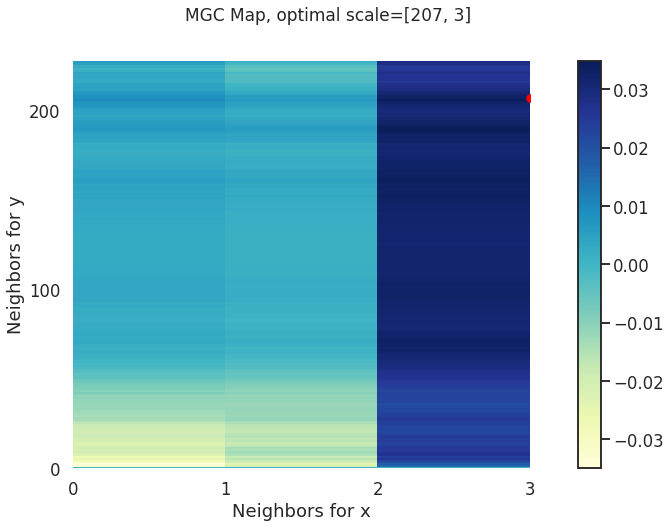

In [44]:
# store mgc outputs as variables
opt_scale = mgc_dict["opt_scale"]
mgc_map = mgc_dict["mgc_map"]

print("Optimal Scale:", opt_scale)
fig, (ax, cax) = plt.subplots(ncols=2, figsize=(9.45, 7.5),  gridspec_kw={"width_ratios":[1, 0.05]})

# draw heatmap and colorbar
ax = sns.heatmap(mgc_map, cmap="YlGnBu", ax=ax, cbar=False)
fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
ax.invert_yaxis()

# optimal scale
ax.scatter(opt_scale[1], opt_scale[0], marker='.', s=200, color='red')

# make plots look nice
fig.suptitle(f"MGC Map, optimal scale={mgc_dict['opt_scale']}", fontsize=17)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Neighbors for x')
ax.set_ylabel('Neighbors for y')
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 100, 200])
ax.xaxis.set_tick_params()
ax.yaxis.set_tick_params()
cax.xaxis.set_tick_params()
cax.yaxis.set_tick_params()
plt.show()